In [1]:
import os
import sys
sys.path.append(os.chdir('../'))

In [2]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import datetime

import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
import src.utils.graph as graph
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

tqdm.pandas()
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1

In [3]:
import src.data as data
import src.utility as utility

In [4]:
#base_df = data.base_structure()

In [5]:
#dataset_train = base_df.merge(data.base_dataset(), how='left')
dataset_train = data.base_dataset()

caching base dataset train


In [6]:
(dataset_train.duplicated(['KEY_2','DATETIME_UTC'])*1).sum()

800

In [7]:
dataset_train.shape

(10833282, 21)

In [8]:
dataset_train.drop_duplicates(['KEY_2','DATETIME_UTC']).shape

(10832482, 21)

In [9]:
dataset_train.head()

,KEY,DATETIME_UTC,KM,SPEED_AVG,SPEED_SD,SPEED_MIN,SPEED_MAX,N_VEHICLES,KEY_2,EMERGENCY_LANE,LANES,ROAD_TYPE,event_index,START_DATETIME_UTC,END_DATETIME_UTC,EVENT_DETAIL,EVENT_TYPE,KM_END,KM_START,KM_EVENT,step_duration
0,0,2018-09-01 01:00:00,443,97.889000,1.144099,97.080,98.698,2,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2018-09-01 03:15:00,443,154.788667,16.287509,137.530,169.890,3,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2018-09-01 12:45:00,443,136.091778,10.759666,124.586,163.418,18,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2018-09-01 19:15:00,443,136.916276,15.089653,114.878,169.890,58,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2018-09-02 09:45:00,443,135.476385,23.125778,82.518,169.890,26,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def time_windows_event(dataset_df, steps_behind=10, steps_after=3, step=15*60):
    """ Filter the dataset to get a window containing n time steps before the beginning
        of the event and m time steps after the end for each involved sensor
        
        dataset_df (df): dataset
        steps_behind (int): n (not including the event start)
        steps_after (int): m (not including the event start)
    """
    # get the first time step of each event for each road
    start_events = dataset_df[dataset_df.event_index.notnull()]
    start_events = start_events[['KEY_2','event_index','DATETIME_UTC']].groupby(['KEY_2','event_index']).min()
    start_events = start_events.reset_index()[['KEY_2','DATETIME_UTC']]
    start_events['sample_id'] = start_events.index
    
    start_delta = datetime.timedelta(seconds=step*steps_behind)
    end_delta = datetime.timedelta(seconds=step*steps_after)
    
    # construct the time window for each event beginning
    start_events['window'] = start_events.apply(lambda x:
                                    list(pd.date_range(start=x.DATETIME_UTC - start_delta,
                                                       end=x.DATETIME_UTC + end_delta,
                                                       freq=f'{step}s')), axis=1)
    start_events = start_events.drop('DATETIME_UTC', axis=1)
    
    # build the filter
    filter_df = pd.DataFrame({ col: np.repeat(start_events[col].values, start_events['window'].str.len())
        for col in start_events.columns.drop('window')
    }).assign(**{'DATETIME_UTC': np.concatenate(start_events['window'].values)})
    
    # join to filter the desired rows
    return dataset_df.merge(filter_df.drop_duplicates(), how='inner', on=['KEY_2','DATETIME_UTC']) \
            .sort_values(['KEY','KM','DATETIME_UTC'])

In [11]:
start_events = dataset_train[dataset_train.event_index.notnull()][['KEY_2','event_index','DATETIME_UTC']]\
                .groupby(['KEY_2','event_index']).min().reset_index()

In [12]:
start_events['sample'] = start_events.reset_index().index

In [13]:
start_events.head()

,KEY_2,event_index,DATETIME_UTC,sample
0,0_337,16789.0,2018-09-05 18:15:00,0
1,0_337,17038.0,2018-09-15 11:15:00,1
2,0_337,17088.0,2018-09-17 16:15:00,2
3,0_337,17208.0,2018-09-20 16:30:00,3
4,0_337,17460.0,2018-10-01 17:00:00,4


In [14]:
start_events.shape

(885, 4)

In [15]:
start_events.reset_index().sort_values(['KEY_2','DATETIME_UTC']).head()

,index,KEY_2,event_index,DATETIME_UTC,sample
9,9,0_337,34620.0,2018-09-01 11:30:00,9
0,0,0_337,16789.0,2018-09-05 18:15:00,0
1,1,0_337,17038.0,2018-09-15 11:15:00,1
2,2,0_337,17088.0,2018-09-17 16:15:00,2
3,3,0_337,17208.0,2018-09-20 16:30:00,3


In [17]:
tw_df = utility.time_windows_event(dataset_train, steps_behind=10, steps_after=3)

Total events found: 885
Filter size: 12390


In [18]:
tw_df.KEY.unique()

array([  0.,   4.,   6.,   8.,  10.,  14.,  16.,  18.,  21.,  25.,  27.,
        29.,  31.,  33.,  37.,  39.,  43.,  46.,  47.,  48.,  50.,  54.,
        56.,  60.,  62.,  64.,  68.,  78.,  80.,  82.,  86.,  88.,  90.,
        96.,  98., 102., 114., 118., 120., 122., 124., 132., 134., 138.,
       146., 150., 154., 158., 164., 166., 172., 174., 178., 188., 198.,
       204., 205., 209., 211., 213., 217., 219., 221., 226., 232., 234.,
       240., 242., 244., 246., 248., 250., 252., 254., 260., 280., 292.,
       296., 298., 312., 314., 322., 324., 326., 334., 338., 340., 344.,
       346., 352., 357., 363., 365., 369., 373., 375., 379., 385., 389.,
       391., 393., 395., 396., 397., 407., 411., 412., 417., 421., 423.,
       429., 431., 433., 439., 441., 445., 449., 451., 453., 455., 457.,
       459., 463., 467., 469., 471., 475., 483., 485., 491., 497., 499.,
       512., 517., 521., 531., 533., 537., 539., 546., 548., 560., 570.,
       574., 576., 578.,  nan])

In [19]:
tw_df.shape

(12390, 22)

In [20]:
tw_df.head()

,KEY,DATETIME_UTC,KM,SPEED_AVG,SPEED_SD,SPEED_MIN,SPEED_MAX,N_VEHICLES,KEY_2,EMERGENCY_LANE,LANES,ROAD_TYPE,event_index,START_DATETIME_UTC,END_DATETIME_UTC,EVENT_DETAIL,EVENT_TYPE,KM_END,KM_START,KM_EVENT,step_duration,sample_id
6916,0.0,2018-09-01 09:00:00,337.0,206.901750,38.640289,59.866,284.768,296.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
10321,0.0,2018-09-01 09:15:00,337.0,213.066542,35.791583,59.866,381.848,343.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
6917,0.0,2018-09-01 09:30:00,337.0,210.929896,36.329373,59.866,302.566,288.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
5720,0.0,2018-09-01 09:45:00,337.0,206.934408,40.507611,59.866,367.286,353.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
2862,0.0,2018-09-01 10:00:00,337.0,213.913824,37.961579,59.866,359.196,273.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9


Number of sensors in road 0: 8


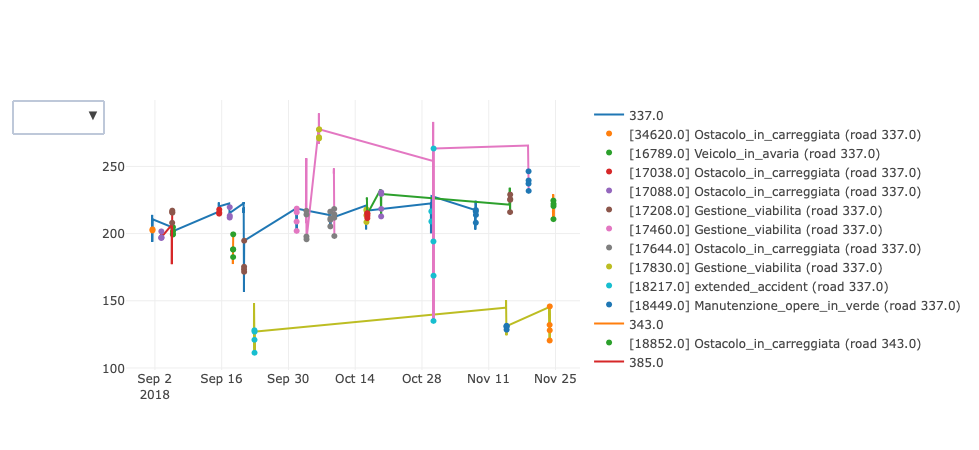

In [21]:
graph.show_speeds_with_events(tw_df, road_key=0, from_datetime='2010', to_datetime='2020')

In [107]:
dataset_train_full = tw_df.round(4).groupby('sample_id').agg({
    'KEY':'first',
    'KM':'first',
    'event_idex':lambda: x: x.values[-4],
    'DATETIME_UTC':list,
    'SPEED_AVG':list, #[list, lambda x: x[0:-4].dropna().mean()],
    'SPEED_SD':list,
    'SPEED_MAX':list,
    'SPEED_MIN':list,
    'N_VEHICLES':list,
    'EMERGENCY_LANE':'first',
    'LANES':'first',
    'ROAD_TYPE':'first',
    'EVENT_DETAIL':lambda x: x.values[-4],
    'EVENT_TYPE':lambda x: x.values[-4]})
dataset_train_full.head()

,KEY,KM,DATETIME_UTC,SPEED_AVG,SPEED_SD,SPEED_MAX,SPEED_MIN,N_VEHICLES,EMERGENCY_LANE,LANES,ROAD_TYPE,EVENT_DETAIL,EVENT_TYPE
sample_id,,,,,,,,,,,,,
0,0.0,337.0,"[2018-09-05 15:45:00, 2018-09-05 16:00:00, 2018-09-05 16:15:00, 2018-09-05 16:30:00, 2018-09-05 16:45:00, 2018-09-05 17:00:00, 2018-09-05 17:15:00, 2018-09-05 17:30:00, 2018-09-05 17:45:00, 2018-09-05 18:00:00, 2018-09-05 18:15:00, 2018-09-05 18:30:00, 2018-09-05 18:45:00, 2018-09-05 19:00:00]","[204.6576, 209.3673, 203.2562, 198.8477, 209.527, 198.3578, 202.14, 206.7908, 204.8874, 197.4534, 199.6642, 199.315, 204.7759, 201.7721]","[48.0839, 37.7934, 48.39, 48.0002, 49.0868, 45.1328, 56.5317, 45.4386, 46.8656, 52.7926, 41.4457, 52.0643, 43.0659, 49.993]","[328.454, 323.6, 294.476, 279.914, 410.972, 323.6, 291.24, 389.938, 406.118, 406.118, 263.734, 292.858, 294.476, 312.274]","[59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866]","[209.0, 173.0, 201.0, 214.0, 201.0, 180.0, 103.0, 186.0, 173.0, 141.0, 107.0, 129.0, 139.0, 193.0]",1.0,2.0,1.0,11.0,Veicolo_in_avaria
1,0.0,337.0,"[2018-09-15 08:45:00, 2018-09-15 09:00:00, 2018-09-15 09:15:00, 2018-09-15 09:30:00, 2018-09-15 09:45:00, 2018-09-15 10:00:00, 2018-09-15 10:15:00, 2018-09-15 10:30:00, 2018-09-15 10:45:00, 2018-09-15 11:00:00, 2018-09-15 11:15:00, 2018-09-15 11:30:00, 2018-09-15 11:45:00, 2018-09-15 12:00:00]","[216.2554, 220.3449, 219.5438, 223.1256, 223.1036, 216.4681, 219.1444, 216.4075, 214.0762, 218.035, 214.8019, 215.5815, 217.9113, 220.268]","[38.7705, 32.5849, 26.5139, 26.5919, 32.5125, 32.7603, 31.1616, 32.9104, 32.1334, 28.4046, 33.1364, 31.9021, 30.1392, 27.3858]","[349.488, 331.69, 289.622, 349.488, 309.038, 383.466, 309.038, 281.532, 328.454, 291.24, 294.476, 330.072, 288.004, 299.33]","[59.866, 59.866, 59.866, 161.8, 64.72, 61.484, 59.866, 59.866, 61.484, 66.338, 59.866, 59.866, 61.484, 161.8]","[250.0, 218.0, 276.0, 286.0, 287.0, 334.0, 265.0, 280.0, 317.0, 299.0, 293.0, 309.0, 287.0, 250.0]",1.0,2.0,1.0,4.0,Ostacolo_in_carreggiata
2,0.0,337.0,"[2018-09-17 13:45:00, 2018-09-17 14:00:00, 2018-09-17 14:15:00, 2018-09-17 14:30:00, 2018-09-17 14:45:00, 2018-09-17 15:00:00, 2018-09-17 15:15:00, 2018-09-17 15:30:00, 2018-09-17 15:45:00, 2018-09-17 16:00:00, 2018-09-17 16:15:00, 2018-09-17 16:30:00, 2018-09-17 16:45:00, 2018-09-17 17:00:00]","[222.4531, 219.0083, 221.2523, 216.126, 215.2863, 215.2823, 220.3851, 220.6781, 213.8336, 213.9111, 211.9201, 219.6707, 213.274, 215.4224]","[33.7272, 33.9104, 34.9611, 37.079, 33.4149, 39.0079, 32.5311, 30.2126, 34.9912, 39.1938, 29.6664, 29.4557, 34.4993, 36.5752]","[376.994, 328.454, 347.87, 328.454, 328.454, 328.454, 343.016, 406.118, 349.488, 283.15, 300.948, 300.948, 286.386, 349.488]","[61.484, 59.866, 63.102, 59.866, 59.866, 59.866, 59.866, 153.71, 59.866, 59.866, 59.866, 63.102, 59.866, 59.866]","[222.0, 249.0, 219.0, 250.0, 263.0, 220.0, 240.0, 208.0, 245.0, 169.0, 256.0, 223.0, 225.0, 255.0]",1.0,2.0,1.0,4.0,Ostacolo_in_carreggiata
3,0.0,337.0,"[2018-09-20 14:00:00, 2018-09-20 14:15:00, 2018-09-20 14:30:00, 2018-09-20 14:45:00, 2018-09-20 15:00:00, 2018-09-20 15:15:00, 2018-09-20 15:30:00, 2018-09-20 15:45:00, 2018-09-20 16:00:00, 2018-09-20 16:15:00, 2018-09-20 16:30:00, 2018-09-20 16:45:00, 2018-09-20 17:00:00, 2018-09-20 17:15:00]","[222.4932, 223.4066, 215.3581, 219.3922, 205.5001, 172.8512, 167.1401, 164.5032, 156.6054, 177.033, 173.4133, 175.3361, 171.4932, 194.6957]","[33.4251, 32.6037, 32.6871, 28.2287, 31.0638, 23.2605, 18.9362, 23.2669, 20.6786, 23.7309, 33.294, 21.7815, 33.8448, 35.4031]","[321.982, 349.488, 328.454, 291.24, 328.454, 244.318, 221.666, 265.352, 208.722, 257.262, 236.228, 245.936, 237.846, 292.858]","[59.866, 59.866, 59.866, 59.866, 61.484, 59.866, 63.102, 61.484, 59.866, 59.866, 59.866, 63.102, 59.866, 59.866]","[266.0, 264.0, 286.0, 264.0, 229.0, 212.0, 243.0, 246.0, 247.0, 258.0, 214.0, 235.0, 219.0, 148.0]",1.0,2.0,1.0,6.0,Gestione_viabilita
4,0.0,337.0,"[2018-10-01 

In [108]:
def split_prediction_fields(row):
    return pd.Series( (row.DATETIME_UTC[:-4], row.DATETIME_UTC[-4:], 
                       row.SPEED_AVG[:-4], row.SPEED_AVG[-4:],
                       row.SPEED_SD[:-4], row.SPEED_SD[-4:],
                       row.SPEED_MAX[:-4], row.SPEED_MAX[-4:],
                       row.SPEED_MIN[:-4], row.SPEED_MIN[-4:],
                       row.N_VEHICLES[:-4], row.N_VEHICLES[-4:]) )
dataset_train_full[['DATETIME_UTC','DATETIME_UTC_Y',
                    'SPEED_AVG','SPEED_AVG_Y',
                    'SPEED_SD','SPEED_SD_Y',
                    'SPEED_MAX','SPEED_MAX_Y',
                    'SPEED_MIN','SPEED_MIN_Y',
                    'N_VEHICLES', 'N_VEHICLES_Y']] = dataset_train_full.progress_apply(split_prediction_fields, axis=1)

In [112]:
for column_name in ['DATETIME_UTC','DATETIME_UTC_Y', 'SPEED_AVG','SPEED_AVG_Y', 'SPEED_SD','SPEED_SD_Y',
                    'SPEED_MAX','SPEED_MAX_Y','SPEED_MIN','SPEED_MIN_Y', 'N_VEHICLES', 'N_VEHICLES_Y']:
    if col_name.endswith('_Y'):
        new_cols = ['col_name_{}'.format(i) for i in range(-10, 0)]
    else:
        new_cols = ['col_name_{}'.format(i) for i in range(0, 4)]
    dataset_train_full[[column_name+str(i) for i in range(n)]] = pd.DataFrame(
        dataset_train_full[column_name].values.tolist(), index= dataset_train_full.index)

dataset_train_full.shape

(885, 103)

In [114]:
dataset_train_full.head()

,KEY,KM,DATETIME_UTC,SPEED_AVG,SPEED_SD,SPEED_MAX,SPEED_MIN,N_VEHICLES,EMERGENCY_LANE,LANES,ROAD_TYPE,EVENT_DETAIL,EVENT_TYPE,DATETIME_UTC_Y,SPEED_AVG_Y,SPEED_SD_Y,SPEED_MAX_Y,SPEED_MIN_Y,N_VEHICLES_Y,DATETIME_UTC0,DATETIME_UTC1,DATETIME_UTC2,DATETIME_UTC3,DATETIME_UTC4,DATETIME_UTC5,DATETIME_UTC6,DATETIME_UTC7,DATETIME_UTC8,DATETIME_UTC9,DATETIME_UTC_Y0,DATETIME_UTC_Y1,DATETIME_UTC_Y2,DATETIME_UTC_Y3,SPEED_AVG0,SPEED_AVG1,SPEED_AVG2,SPEED_AVG3,SPEED_AVG4,SPEED_AVG5,SPEED_AVG6,SPEED_AVG7,SPEED_AVG8,SPEED_AVG9,SPEED_AVG_Y0,SPEED_AVG_Y1,SPEED_AVG_Y2,SPEED_AVG_Y3,SPEED_SD0,SPEED_SD1,SPEED_SD2,SPEED_SD3,SPEED_SD4,SPEED_SD5,SPEED_SD6,SPEED_SD7,SPEED_SD8,SPEED_SD9,SPEED_SD_Y0,SPEED_SD_Y1,SPEED_SD_Y2,SPEED_SD_Y3,SPEED_MAX0,SPEED_MAX1,SPEED_MAX2,SPEED_MAX3,SPEED_MAX4,SPEED_MAX5,SPEED_MAX6,SPEED_MAX7,SPEED_MAX8,SPEED_MAX9,SPEED_MAX_Y0,SPEED_MAX_Y1,SPEED_MAX_Y2,SPEED_MAX_Y3,SPEED_MIN0,SPEED_MIN1,SPEED_MIN2,SPEED_MIN3,SPEED_MIN4,SPEED_MIN5,SPEED_MIN6,SPEED_MIN7,SPEED_MIN8,SPEED_MIN9,SPEED_MIN_Y0,SPEED_MIN_Y1,SPEED_MIN_Y2,SPEED_MIN_Y3,N_VEHICLES0,N_VEHICLES1,N_VEHICLES2,N_VEHICLES3,N_VEHICLES4,N_VEHICLES5,N_VEHICLES6,N_VEHICLES7,N_VEHICLES8,N_VEHICLES9,N_VEHICLES_Y0,N_VEHICLES_Y1,N_VEHICLES_Y2,N_VEHICLES_Y3
sample_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,337.0,"[2018-09-05 15:45:00, 2018-09-05 16:00:00, 2018-09-05 16:15:00, 2018-09-05 16:30:00, 2018-09-05 16:45:00, 2018-09-05 17:00:00, 2018-09-05 17:15:00, 2018-09-05 17:30:00, 2018-09-05 17:45:00, 2018-09-05 18:00:00]","[204.6576, 209.3673, 203.2562, 198.8477, 209.527, 198.3578, 202.14, 206.7908, 204.8874, 197.4534]","[48.0839, 37.7934, 48.39, 48.0002, 49.0868, 45.1328, 56.5317, 45.4386, 46.8656, 52.7926]","[328.454, 323.6, 294.476, 279.914, 410.972, 323.6, 291.24, 389.938, 406.118, 406.118]","[59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866]","[209.0, 173.0, 201.0, 214.0, 201.0, 180.0, 103.0, 186.0, 173.0, 141.0]",1.0,2.0,1.0,11.0,Veicolo_in_avaria,"[2018-09-05 18:15:00, 2018-09-05 18:30:00, 2018-09-05 18:45:00, 2018-09-05 19:00:00]","[199.6642, 199.315, 204.7759, 201.7721]","[41.4457, 52.0643, 43.0659, 49.993]","[263.734, 292.858, 294.476, 312.274]","[59.866, 59.866, 59.866, 59.866]","[107.0, 129.0, 139.0, 193.0]",2018-09-05 15:45:00,2018-09-05 16:00:00,2018-09-05 16:15:00,2018-09-05 16:30:00,2018-09-05 16:45:00,2018-09-05 17:00:00,2018-09-05 17:15:00,2018-09-05 17:30:00,2018-09-05 17:45:00,2018-09-05 18:00:00,2018-09-05 18:15:00,2018-09-05 18:30:00,2018-09-05 18:45:00,2018-09-05 19:00:00,204.6576,209.3673,203.2562,198.8477,209.5270,198.3578,202.1400,206.7908,204.8874,197.4534,199.6642,199.3150,204.7759,201.7721,48.0839,37.7934,48.3900,48.0002,49.0868,45.1328,56.5317,45.4386,46.8656,52.7926,41.4457,52.0643,43.0659,49.9930,328.454,323.600,294.476,279.914,410.972,323.600,291.240,389.938,406.118,406.118,263.734,292.858,294.476,312.274,59.866,59.866,59.866,59.866,59.866,59.866,59.866,59.866,59.866,59.866,59.866,59.866,59.866,59.866,209.0,173.0,201.0,214.0,201.0,180.0,103.0,186.0,173.0,141.0,107.0,129.0,139.0,193.0
1,0.0,337.0,"[2018-09-15 08:45:00, 2018-09-15 09:00:00, 2018-09-15 09:15:00, 2018-09-15 09:30:00, 2018-09-15 09:45:00, 2018-09-15 10:00:00, 2018-09-15 10:15:00, 2018-09-15 10:30:00, 2018-09-15 10:45:00, 2018-09-15 11:00:00]","[216.2554, 220.3449, 219.5438, 223.1256, 223.1036, 216.4681, 219.1444, 216.4075, 214.0762, 218.035]","[38.7705, 32.5849, 26.5139, 26.5919, 32.5125, 32.7603, 31.1616, 32.9104, 32.1334, 28.4046]","[349.488, 331.69, 289.622, 349.488, 309.038, 383.466, 309.038, 281.532, 328.454, 291.24]","[59.866, 59.866, 59.866, 161.8, 64.72, 61.484, 59.866, 59.866, 61.484, 66.338]","[250.0, 218.0, 276.0, 286.0, 287.0, 334.0, 265.0, 280.0, 317.0, 299.0]",1.0,2.0,1.0,4.0,Ostacolo_in_carreggiata,"[2018-09-15 11:15:00, 2018-09-15 11:30:00, 2018-09-15 11:45:00, 2018-09-15 12:00:00]","[214.8019, 215.5815, 217.9113, 220.268]","[33.1364, 31.9021, 30.1392, 27.3858]","[294.476, 330.072, 

In [117]:
speed_df_train = pd.read_csv('../resources/dataset/originals/speeds_train.csv.gz', compression='gzip')
avg_speed_km = speed_df_train.groupby(by=['KEY','KM']).mean()['SPEED_AVG']
avg_speed_km.head()

FileNotFoundError: [Errno 2] No such file or directory: '../resources/dataset/originals/speeds_train.csv.gz'